In [60]:
import copy
# TODO: investigate death works well and internal death stats
# TODO: fix die-adaptive lr, show usefull stat instead of logs
# TODO: Collect internal statistics of history of Neurons at their death point (like: values, how fast changed, etc.)
# "batch norm analog" - i.e. collector neuron - when things will go slow with reasonable dataset - likely cifar10, then see if speed improvement
# Separate livenet core and high-level api?
# TODO: make amount of dangle/useless neurons updated during Neuron creation/connection?

import random
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
import importlib
from ai_libs.basic.deep_reload import deep_reload
import livenet
deep_reload(livenet)
core = livenet.core
deep_reload(core)
deep_reload(livenet.core.livenet)
importlib.reload(livenet.core.livenet)
import ai_libs.simple_log as simple_log
from ai_libs.simple_log import LOG
simple_log.level = simple_log.LogLevel.INFO
import math
from matplotlib import pyplot as plt
%matplotlib
plt.ion()
livenet.core.utils.set_seed()
var = 42
print(torch.__version__)
np.set_printoptions(precision=3)
%precision 4



Using matplotlib backend: module://matplotlib_inline.backend_inline
2.3.1+cu121


'%.4f'

In [2]:
downscale = (8, 8)
test_x, test_y = livenet.datasets.to_plain(*livenet.datasets.get_cifar10_test(), downscale=downscale, to_gray=True)
train_x, train_y = livenet.datasets.to_plain(*livenet.datasets.get_cifar10_train(), downscale=downscale, to_gray=True)


Files already downloaded and verified
Files already downloaded and verified


In [3]:
network = livenet.nets.create_perceptron(train_x.shape[1], 11, 10)
batch_iterator = livenet.gen_utils.batch_iterator(train_x, train_y, batch_size=1000)
criterion = livenet.nets.criterion_classification_n
optimizer = livenet.nets.create_optimizer(network)
optimizer.learning_rate = 0.01
trainer = livenet.net_trainer.NetTrainer(network, batch_iterator, criterion, optimizer, epoch_size=10)

Iˈ0.000 S0 became useless livenet/core/death.py:68
Iˈ0.000 S1 became useless livenet/core/death.py:68
Iˈ0.000 S2 became useless livenet/core/death.py:68
Iˈ0.000 S3 became useless livenet/core/death.py:68
Iˈ0.000 S4 became useless livenet/core/death.py:68
Iˈ0.000 S5 became useless livenet/core/death.py:68
Iˈ0.000 S6 became useless livenet/core/death.py:68
Iˈ0.001 S7 became useless livenet/core/death.py:68
Iˈ0.001 S8 became useless livenet/core/death.py:68
Iˈ0.001 S9 became useless livenet/core/death.py:68
Iˈ0.001 S10 became useless livenet/core/death.py:68
Iˈ0.001 S11 became useless livenet/core/death.py:68
Iˈ0.001 S12 became useless livenet/core/death.py:68
Iˈ0.001 S13 became useless livenet/core/death.py:68
Iˈ0.001 S14 became useless livenet/core/death.py:68
Iˈ0.001 S15 became useless livenet/core/death.py:68
Iˈ0.001 D0 became dangle livenet/core/death.py:59
Iˈ0.002 D1 became dangle livenet/core/death.py:59
Iˈ0.002 D2 became dangle livenet/core/death.py:59
Iˈ0.002 D3 became dangle liv

In [62]:
simple_log.level = simple_log.LogLevel.DEBUG
network.context.regularization_l1 = 0.001
optimizer.learning_rate = 0.001
trainer.step(200)


Dˈ0.000 Would die but at least one history value is above threshold n_small=327 history_len=1939 livenet/core/death.py:43
Dˈ0.000 S10->N1 didn't die because of not small values in it's history livenet/core/livenet.py:208
Dˈ0.003 Would die but at least one history value is above threshold n_small=38 history_len=1543 livenet/core/death.py:43
Dˈ0.004 S2->N2 didn't die because of not small values in it's history livenet/core/livenet.py:208
Dˈ0.006 Would die but at least one history value is above threshold n_small=448 history_len=1291 livenet/core/death.py:43
Dˈ0.006 S12->N2 didn't die because of not small values in it's history livenet/core/livenet.py:208
Dˈ0.009 Would die but at least one history value is above threshold n_small=1449 history_len=1613 livenet/core/death.py:43
Dˈ0.010 S12->N4 didn't die because of not small values in it's history livenet/core/livenet.py:208
Dˈ0.013 Would die but at least one history value is above threshold n_small=1270 history_len=1492 livenet/core/death.

In [65]:
pred = network(test_x)
pred_bin = np.argmax(pred.detach().numpy(), axis=1, keepdims=True)
diff = test_y.numpy() - pred_bin
f"accuracy {len(diff[diff == 0]) / len(diff)}"


'accuracy 0.3053'

Using matplotlib backend: module://matplotlib_inline.backend_inline


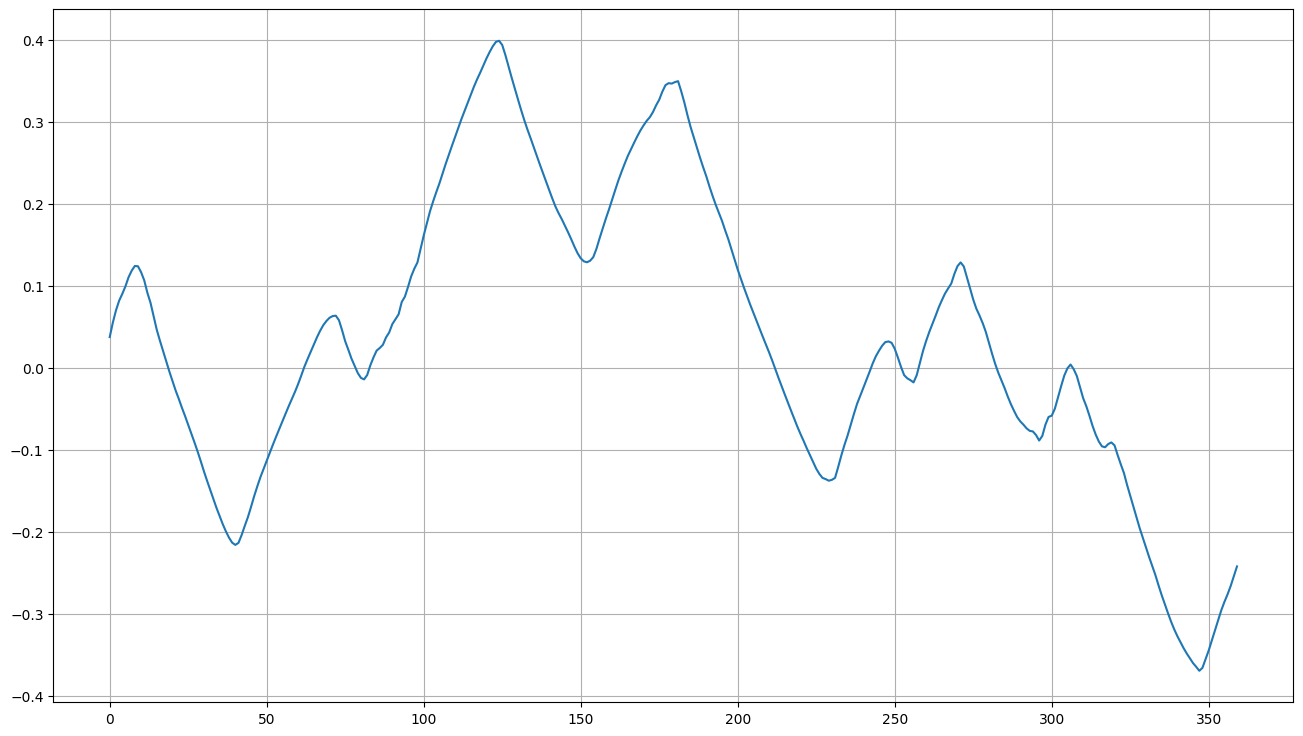

In [64]:
%matplotlib
plt.ion()

def param_amount(param):
    val = len(param["params"])
    return val

def param_max(param):
    val = np.max(np.abs(param["params"]))
    return val

def param_picker1(param):
    try:
        val0 = param["params"]["N9->D7"].item()
    except KeyError:
        val0 = 0.
    return val0

def get_param_values(history, picker):
    values = []
    for entry in history:
        values.append(picker(entry))
    return values

plt.figure(figsize=(16, 9))
values = get_param_values(trainer.history, param_picker1)
plt.grid()
plt.plot(values)

# accum = core.stat_utils.AccumStat()
# accum.add_value(trainer.network.parameters())
# accum.plot()


In [47]:
for name, p in sorted(network.named_parameters(),key=lambda x: len(x[0]) + ord(x[0][0]) / 1000.):
    print(name, f"{p.item():.2f}")


D0 1.04
D1 -1.94
D2 0.49
D3 0.06
D4 0.65
D5 0.06
D6 -0.49
D7 0.53
D8 -0.36
D9 -0.58
N0 0.52
N1 1.54
N2 -0.06
N3 -2.19
N4 0.46
N5 0.27
N6 0.27
N7 1.37
N8 0.02
N9 0.02
N10 0.08
N0->D0 0.50
N0->D1 -1.27
N0->D2 -0.23
N0->D3 -0.07
N0->D4 0.23
N0->D5 -0.63
N0->D6 -0.34
N0->D7 -0.86
N0->D8 1.48
N0->D9 -2.00
N1->D0 -0.03
N1->D1 -0.47
N1->D2 0.20
N1->D3 -0.19
N1->D4 -0.04
N1->D5 -0.04
N1->D6 -0.14
N1->D7 -0.41
N1->D8 0.04
N1->D9 -0.74
N2->D0 1.03
N2->D1 1.91
N2->D2 -1.07
N2->D3 0.03
N2->D4 -1.33
N2->D5 0.14
N2->D6 -0.94
N2->D7 -0.84
N2->D8 0.86
N2->D9 1.57
N3->D3 0.05
N4->D0 -0.23
N4->D1 0.35
N4->D2 -0.11
N4->D3 0.04
N4->D4 -0.07
N4->D5 -0.15
N4->D6 0.07
N4->D7 0.88
N4->D8 0.36
N4->D9 0.78
N5->D0 0.43
N5->D1 -0.16
N5->D2 0.36
N5->D3 0.75
N5->D4 0.32
N5->D5 0.65
N5->D6 -0.34
N5->D7 0.87
N5->D8 -1.20
N5->D9 -0.12
N6->D0 0.51
N6->D1 0.88
N6->D2 -0.23
N6->D3 -0.08
N6->D4 0.00
N6->D5 -0.32
N6->D6 0.03
N6->D7 -0.57
N6->D8 0.60
N6->D9 0.56
N7->D0 -0.91
N7->D1 1.34
N7->D2 0.13
N7->D4 0.24
N7->D5 0.05
N